Script for 'building_heating' program in Python<br>
Licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

In the first part of the analysis, we construct a schematic representation of the building.

In [1]:
# The magic command "%matplotlib notebook" to make interactive plots within the Jupyter Notebook
# Import numpy library (for arrays operations)
# Import matplotlib.pyplot interface (for MATLAB-like plots)

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Range of coordinates indices x, y, z for the building plot

x, y, z = np.indices((12, 26, 6))

In [3]:
# Definition of the building volumes and colors

ground = (x < 12) & (y < 26) & (z < 1)
floors = (x < 12) & (y < 26) & (1 <= z) & (z < 6)
building = ground | floors
    
building_color = np.empty(building.shape, dtype=object)
building_color[ground] = 'grey'
building_color[floors] = 'white'

In [4]:
# Definition of the 4th floor apartments volumes and colors

apart_41 = (0 <= x) & (x < 12) & (19 <= y) & (y < 26) & (3 <= z) & (z < 4)
apart_42 = (8 <= x) & (x < 12) & (10 <= y) & (y < 19) & (3 <= z) & (z < 4)
apart_43 = (6 <= x) & (x < 12) & (0 <= y) & (y < 8) & (3 <= z) & (z < 4)
apart_44 = (0 <= x) & (x < 6) & (0 <= y) & (y < 10) & (3 <= z) & (z < 4)
apart_45 = (0 <= x) & (x < 6) & (10 <= y) & (y < 17) & (3 <= z) & (z < 4)
apartments = apart_41 | apart_42 | apart_43 | apart_44 | apart_45

apartments_color = np.empty(building.shape, dtype=object)
apartments_color[apart_41] = 'gold'
apartments_color[apart_42] = 'red'
apartments_color[apart_43] = 'blue'
apartments_color[apart_44] = 'violet'
apartments_color[apart_45] = 'green'

<IPython.core.display.Javascript object>


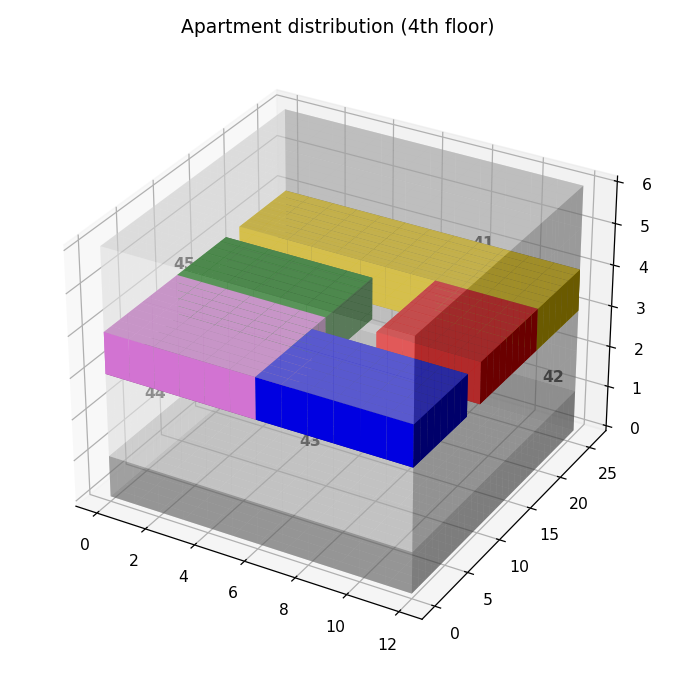

In [5]:
# Interactive 3D plot of the building

# Parameters, title and text of the 3D plot

ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
ax.voxels(building, facecolors=building_color, alpha=0.4)
ax.voxels(apartments, facecolors=apartments_color)

plt.title('Apartment distribution (4th floor)')

ax.text(8.5, -3, 3.3, '43', weight='bold')
ax.text(2.5, -3, 3.3, '44', weight='bold')
ax.text(7, 29, 3.3, '41', weight='bold')
ax.text(13.5, 13.5, 3.3, '42', weight='bold')
ax.text(-1.5, 14.5, 3.3, '45', weight='bold')

plt.tight_layout()

In the next part, we use Python librarires to set up a connection to the MySQL database containing the data of the building.

In [6]:
# Import os module (for interacting with the operating system)
# Import pandas library (for data analysis in Python)
# Import create_engine from the sqlalchemy toolkit (standard SQL toolkit in Python)
# Import load_dotenv from the dotenv module (for setting environment variables)

import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [7]:
# Load from a (hidden) .env file the MySQL credentials of the mysql database of the building

load_dotenv()
user = os.getenv('MySQL_USER')
passwd = os.getenv('MySQL_PASSWORD')
host = os.getenv('MySQL_HOST')
port = os.getenv('MySQL_PORT')
db = os.getenv('MySQL_DB')

In [8]:
# Create a connection ("engine") to the MySQL database using the credentials

engine = create_engine('mysql://%s:%s@%s:%s/%s' % (user, passwd, host, port, db))

The analysis involves 3 tables from the database, "Apartments", "Power" and "Temperatures", that we now describe.

The Apartments table contains the list of all units of the building (31 apartments + 4 weather stations). The "esmart_id" is the identification number given to each unit by the firm eSMART. The column "name" is a more intuitive identification number for the units. For instance, the name "43" corresponds to floor 4, apartment 3.

In [85]:
# Read the Apartments table into a DataFrame "df_apart"

df_apart = pd.read_sql('SELECT * FROM Apartments', engine)
df_apart.head()

,esmart_id,name
0,1046,11
1,1047,12
2,1048,13
3,1049,14
4,1050,15


For future use, we store in a DataFrame "df_dim" the names, the areas and the volumes of the 31 units of the building provided by the architect.

In [174]:
units = tuple(list(df_apart['name'])[:31])

areas = (127.1, 55.8, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 127.1, 55.8, 78.1, 90.2,
         46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 82.5, 70.2, 120.6,
         85.5, 90.2, 46.9)

volumes = (330.46, 145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 330.46,
           145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 295.36, 180.18,
           203.06, 234.52, 121.94, 231, 203.58, 349.74, 247.95, 261.58, 136.01)

df_dim = pd.DataFrame({'unit': units, 'area': areas, 'volume': volumes}).set_index('unit')
df_dim.head()

,area,volume
unit,,
11,127.1,330.46
12,55.8,145.08
13,78.1,203.06
14,90.2,234.52
15,46.9,121.94


The Power table contains data about power consumption for heating of each unit starting from 2017-10-12. Each row of the table contains the "apartment_id" (= esmart_id), the "module_id" of the module taking the measure, namely,

- <b>17</b> for electric power measured in Watt [W],
- <b>18</b> for the energy measured in Watt-hour [W⋅h]

the "date" of the measure and the "value" measured by the module.

In [86]:
# Read the first 100 rows of Power table into a DataFrame "df_power"

df_power = pd.read_sql('SELECT * FROM Power LIMIT 100', engine)
df_power.head()

,apartment_id,module_id,date,value
0,1026,17,2017-10-12,9242
1,1026,17,2017-10-13,10658
2,1026,17,2017-10-14,11523
3,1026,17,2017-10-15,12394
4,1026,17,2017-10-16,13260


The Temperatures table contains data about temperatures of each unit starting from 2021-03-15. Each row of the table contains the "apartment_id", the "module_id" for the room location of the module taking the measure, the "date" of the measure, the "action" of the module (<b>get</b> for temperature measured in the room and <b>set</b> for temperature set in the room) and the "value" of the temperature.

In [87]:
# Read the first 100 rows of Temperatures table into a DataFrame "df_temp"

df_temp = pd.read_sql('SELECT * FROM Temperatures LIMIT 100', engine)
df_temp.head()

,apartment_id,module_id,date,action,value
0,1026,1,2021-03-15 11:46:46,set,22.0
1,1026,1,2021-03-15 11:56:56,set,22.0
2,1026,1,2021-03-15 12:07:06,set,22.0
3,1026,1,2021-03-15 12:17:17,set,22.0
4,1026,1,2021-03-15 12:27:27,set,22.0


In this part of the analysis, we retrieve and plot in pie chart and bar chart data about energy consumption of each unit of the building, over any prescribed period of time defined by a "start_date" and an "end_date".

In [200]:
# Set start_date and end_date for the DataFrame of energy consumption

start_date = '"2018-01-01"'
end_date = '"2018-12-31"'

# Read, for each unit of the building, the first energy after the start date into a DataFrame "df_start"
# We dive "Power.value" by 1000 to get energies in [kW⋅h]

df_start = pd.read_sql('SELECT Apartments.name, Power.date AS \'initial date\', \
                   Power.value/1000 AS \'initial energy [kW⋅h]\' \
                   FROM Power INNER JOIN Apartments ON Power.apartment_id=Apartments.esmart_id \
                   WHERE Power.module_id=18 AND Power.date>=%s \
                   GROUP BY Apartments.name' % start_date, engine)

# Read, for each unit of the building, the last energy before the end date into a DataFrame "df_end"
# We dive "Power.value" by 1000 to get energies in [kW⋅h]

df_end = pd.read_sql('SELECT Apartments.name, Power.date AS \'final date\', \
                   Power.value/1000 AS \'final energy [kW⋅h]\' \
                   FROM Power INNER JOIN Apartments ON Power.apartment_id=Apartments.esmart_id \
                   WHERE Power.module_id=18 AND Power.date<=%s \
                   ORDER BY Power.date DESC LIMIT 31' % end_date, engine)

# Merging 'df_start' and 'df_end' into a DataFrame 'df_energy' (using 'name' as key)
# (in 2018 there are missing measures; the first measure for unit "O2" is at initial_date "2018-10-10")

df_energy = pd.merge(df_start, df_end, how='left', on='name')
df_energy.head()

,name,initial date,initial energy [kW⋅h],final date,final energy [kW⋅h]
0,11,2018-01-01,2350.0,2018-12-31,5364.0
1,12,2018-01-01,1119.0,2018-12-31,3365.0
2,13,2018-01-01,1266.0,2018-12-31,3644.0
3,14,2018-01-01,241.0,2018-12-31,2254.0
4,15,2018-01-01,1586.0,2018-12-31,4378.0


We use the data stored in the DataFrame "df_energy" to produce a pie chart of of the heating energy consumption of each unit of the building.

<IPython.core.display.Javascript object>


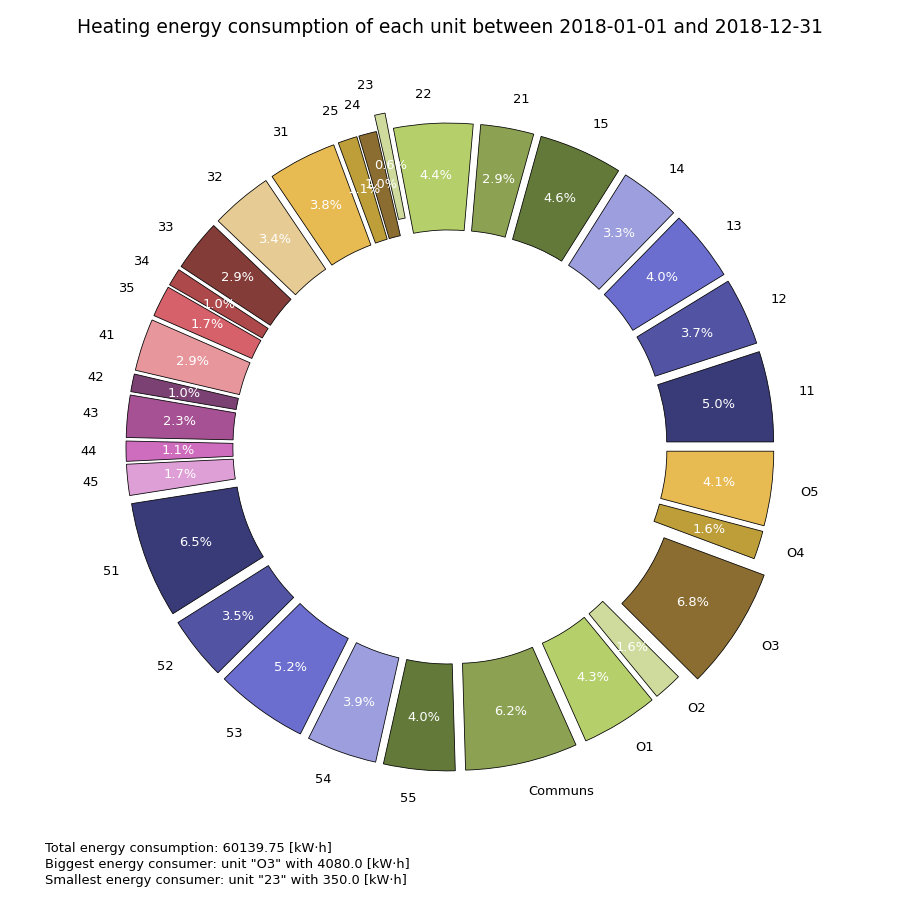

In [212]:
# Set in a "data" list the differences between final energy and initial energy
# Store in variables "max_unit" and "min_unit" the units having maximum (resp. minimum) energy consumption

data = (df_energy['final energy [kW⋅h]']-df_energy['initial energy [kW⋅h]']).tolist()
max_unit = units[data.index(max(data))]
min_unit = units[data.index(min(data))]

# Check if there was energy consumption during the period before doing the plot

if min(data)>0:

    # Set in a "scales" the corresponding list the scales of the pie chart wedges
    # Set in a "wedges" dictionary the properties of the pie chart wedges
    # Set in a "colors" list the colors of the pie chart wedges
    # See https://matplotlib.org/stable/tutorials/colors/colormaps.html for details
    
    scales = [0.15 if data[i] == max(data) or data[i] == min(data) else 0.1 for i in range(len(data))]
    wedges = {'width':0.33, 'edgecolor':'black', 'linewidth':0.5}
    colors = plt.colormaps['tab20b'](range(20))

    # Parameters, title and legend of the pie chart plot

    _, ax = plt.subplots(figsize=(8, 8))
    _, _, pcts = ax.pie(data, labels=units, explode=scales, radius=0.9, autopct='%.1f%%', colors=colors,
                    wedgeprops=wedges, pctdistance=0.82, textprops={'size': 'small'})
    plt.setp(pcts, color='w')

    ax.set_title('Heating energy consumption of each unit between %s and %s' % (eval(start_date), eval(end_date)))
    
    ax.text(0, 0, 'Total energy consumption: %s [kW⋅h]' % round(sum(data), 2),
            transform=ax.transAxes, size='small')
    ax.text(0, -0.02, 'Biggest energy consumer: unit "%s" with %s [kW⋅h]' \
            % (max_unit, max(data)), transform=ax.transAxes, size='small')
    ax.text(0, -0.04, 'Smallest energy consumer: unit "%s" with %s [kW⋅h]' \
            % (min_unit, min(data)), transform=ax.transAxes, size='small')

    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start_date), eval(end_date)))

<IPython.core.display.Javascript object>


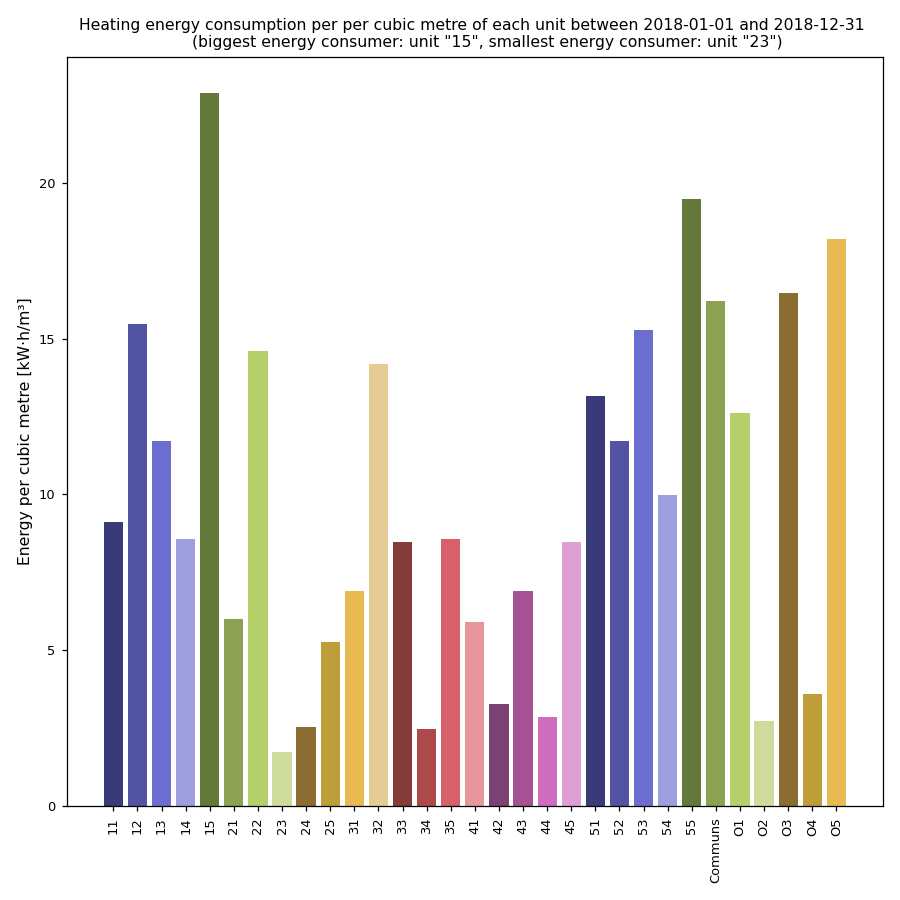

In [204]:
# Bar chart of the heating energy consumption per cubic metre of each unit

if min(data)>0:

    # Set in a "data_pcm" list the differences between final energy and initial energy per cubic metre

    data_pcm = [data[i]/volumes[i] for i in range(len(data))]

    # Parameters and title of the pie chart plot

    _, ax = plt.subplots(figsize=(8, 8))
    ax.bar(units, data_pcm, color=colors)
    plt.xticks(rotation=90)
    ax.set_ylabel('Energy per cubic metre [kW⋅h/m\u00b3]')

    ax.set_title('Heating energy consumption per per cubic metre of each unit between %s and %s \n \
    (biggest energy consumer: unit \"%s\", smallest energy consumer: unit \"%s\")'
                 % (eval(start_date), eval(end_date), units[data_pcm.index(max(data_pcm))],
                    units[data_pcm.index(min(data_pcm))]), size='medium')

    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start_date), eval(end_date)))

In [205]:
initial_date = '"2022-01-01"'
final_date = '"2022-12-31"'

dflist_get, dflist_set = [], []

for unit in units:
    temp_get = pd.read_sql('SELECT DATE(Temperatures.date) AS date, ROUND(AVG(Temperatures.value),2) AS \'unit %s (get)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="get" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (unit, unit, initial_date, final_date), engine)
    
    temp_set = pd.read_sql('SELECT DATE(Temperatures.date) AS date, ROUND(AVG(Temperatures.value),2) AS \'unit %s (set)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="set" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (unit, unit, initial_date, final_date), engine)
    
    dflist_get.append(temp_get)
    dflist_set.append(temp_set)

In [206]:
from functools import reduce

merge_get = reduce(lambda x, y: pd.merge(round(x,2), round(y,2), on='date', how='outer'), dflist_get)
df_get = merge_get.copy(deep=True)

masked_get = np.ma.masked_array(merge_get.drop('date', axis=1), np.isnan(merge_get.drop('date', axis=1)))
df_get['mean (get)'] = np.ma.average(masked_get, axis=1, weights=volumes)
df_get['mean (get)'] = round(df_get['mean (get)'], 2)

df_get['min (get)'] = round((merge_get.drop('date', axis=1)).min(axis=1), 2)
df_get['max (get)'] = round((merge_get.drop('date', axis=1)).max(axis=1), 2)

merge_set = reduce(lambda x, y: pd.merge(round(x,2), round(y,2), on='date', how='outer'), dflist_set)
df_set = merge_set.copy(deep=True)

df_set['mean (set)'] = round((merge_set.drop('date', axis=1)).mean(axis=1), 2)
df_set['min (set)'] = round((merge_set.drop('date', axis=1)).min(axis=1), 2)
df_set['max (set)'] = round((merge_set.drop('date', axis=1)).max(axis=1), 2)

df_get.head()

,date,unit 11 (get),unit 12 (get),unit 13 (get),unit 14 (get),unit 15 (get),unit 21 (get),unit 22 (get),unit 23 (get),unit 24 (get),...,unit 55 (get),unit Communs (get),unit O1 (get),unit O2 (get),unit O3 (get),unit O4 (get),unit O5 (get),mean (get),min (get),max (get)
0,2022-02-07,21.71,22.12,22.50,22.41,22.07,21.09,22.62,21.86,21.24,...,21.72,20.99,20.31,21.16,20.94,21.78,23.43,21.60,19.99,23.43
1,2022-02-08,21.39,22.20,22.18,22.51,21.00,21.05,22.65,21.67,21.30,...,21.83,20.99,20.35,21.39,20.84,21.77,23.22,21.59,20.35,23.22
2,2022-02-09,21.37,22.32,22.20,22.38,22.04,21.05,22.70,21.82,21.25,...,21.94,21.00,20.35,21.36,21.13,21.79,23.18,21.62,20.35,23.18
3,2022-02-10,21.46,22.59,22.24,22.55,22.19,21.16,23.23,22.02,21.42,...,22.13,21.14,20.32,21.57,21.49,21.80,23.15,21.75,20.32,23.23
4,2022-02-11,21.45,22.74,22.18,22.53,22.29,21.16,22.98,22.30,21.47,...,22.21,20.92,20.30,21.39,21.47,21.84,23.28,21.75,20.30,23.28


<IPython.core.display.Javascript object>


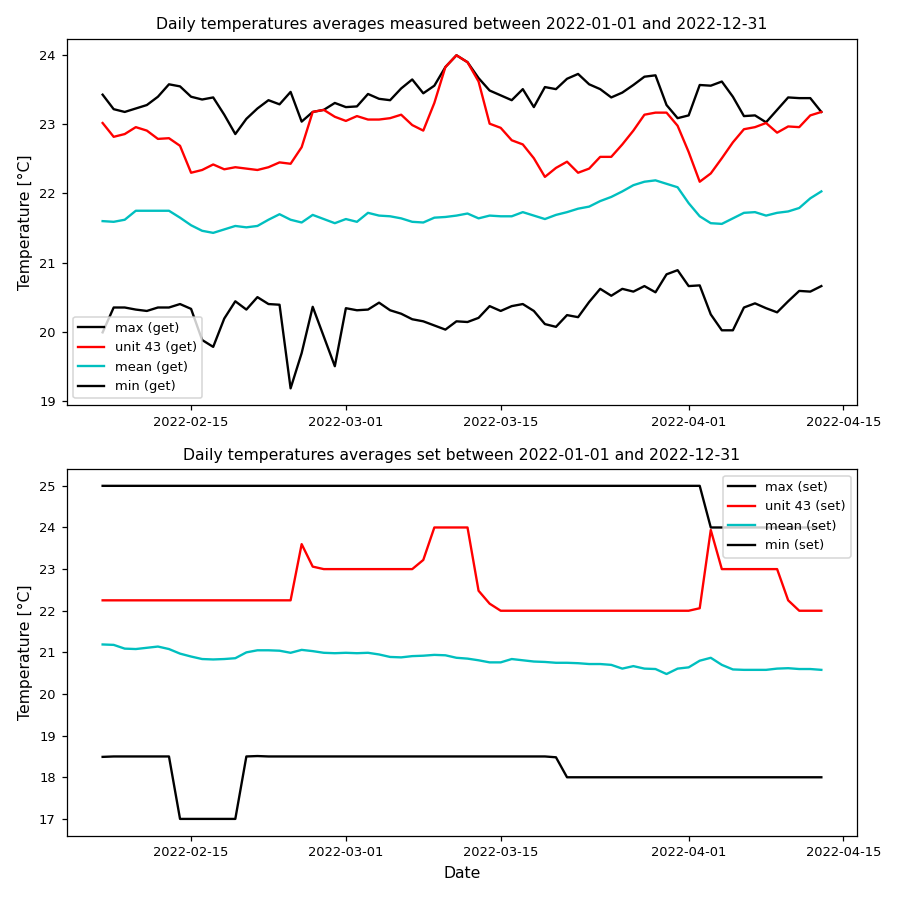

In [207]:
unit = '43'

_, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

ax1.plot(df_get['date'], df_get['max (get)'], color='k', label='max (get)')
ax1.plot(df_get['date'], df_get['unit %s (get)'% unit], color='r', label='unit %s (get)' % unit)
ax1.plot(df_get['date'], df_get['mean (get)'], color='c', label='mean (get)')
ax1.plot(df_get['date'], df_get['min (get)'], color='k', label='min (get)')

ax1.set_title('Daily temperatures averages measured between %s and %s'
              % (eval(initial_date), eval(final_date)), size='medium')

ax1.legend(fontsize='small',)
ax1.set_ylabel('Temperature [°C]')

ax2.plot(df_set['date'], df_set['max (set)'], color='k', label='max (set)')
ax2.plot(df_set['date'], df_set['unit %s (set)'% unit], color='r', label='unit %s (set)' % unit)
ax2.plot(df_set['date'], df_set['mean (set)'], color='c', label='mean (set)')
ax2.plot(df_set['date'], df_set['min (set)'], color='k', label='min (set)')

ax2.set_title('Daily temperatures averages set between %s and %s'
              % (eval(initial_date), eval(final_date)), size='medium')

ax2.legend(fontsize='small')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature [°C]')

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

plt.tight_layout()

In [209]:
deviations = pd.DataFrame()

for unit in units:
    deviations['unit %s deviation (get)'% unit] = df_get['unit %s (get)'% unit] - df_get['mean (get)']
    deviations['unit %s deviation (set)'% unit] = df_set['unit %s (set)'% unit] - df_set['mean (set)']

deviations.loc[:, 'unit 11 deviation (set)'::2]
    
MD = pd.DataFrame()
MD['unit'] = units
MD['mean deviation (get)'] = deviations.loc[:, ::2].mean().tolist()
MD['mean deviation (set)'] = deviations.loc[:, 'unit 11 deviation (set)'::2].mean().tolist()
MD = round(MD, 2)
MD.sort_values(by=['mean deviation (get)'], inplace=True, ascending=False)
MD.head()

,unit,mean deviation (get),mean deviation (set)
30,O5,1.65,3.10
17,43,1.12,1.68
3,14,0.70,1.37
19,45,0.68,0.49
12,33,0.68,1.22
